In [60]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, concatenate, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras import backend as K
from keras.layers.core import SpatialDropout2D
from keras.optimizers import Adam, SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

In [61]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [62]:
filelist_trainx_ph2 = sorted(glob.glob('../input/*/*/trainx/*.bmp'), key=numericalSort)
X_train_ph2 = np.array([np.array(Image.open(fname)) for fname in filelist_trainx_ph2])

filelist_trainy_ph2 = sorted(glob.glob('../input/*/*/trainy/*.bmp'), key=numericalSort)
Y_train_ph2 = np.array([np.array(Image.open(fname)) for fname in filelist_trainy_ph2])

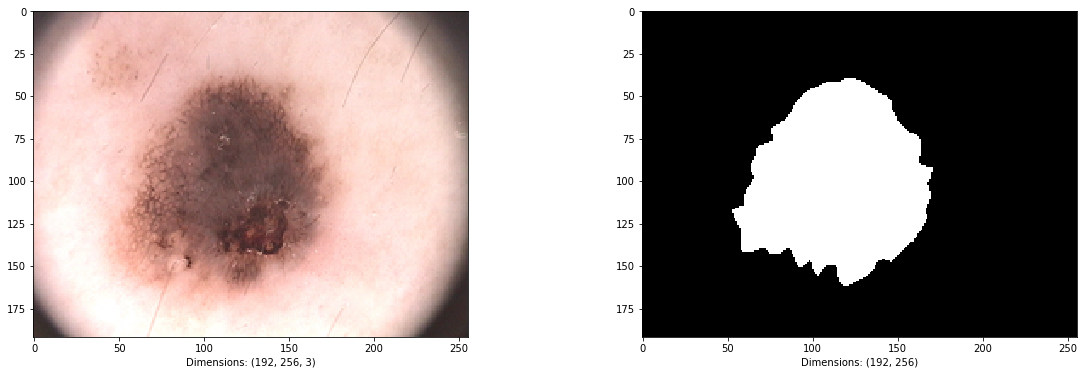

In [63]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.imshow(X_train_ph2[2])
plt.xlabel("Dimensions: "+str(np.array(X_train_ph2[0]).shape))
plt.subplot(1,2,2)
plt.imshow(Y_train_ph2[2], plt.cm.binary_r)
plt.xlabel("Dimensions: "+str(np.array(Y_train_ph2[0]).shape))
plt.show()

In [64]:
def resize(filename, size = (256,192)):
    im = Image.open(filename)
    im_resized = im.resize(size, Image.ANTIALIAS)
    return (im_resized)
#   im_resized.save('/resized_ph2/X_train/X_img_'+str(i)+'.bmp', dpi = (192,256))

In [65]:
X_train_ph2_resized = []
Y_train_ph2_resized = []

for i in range(len(filelist_trainx_ph2)):
    X_train_ph2_resized.append(resize(filelist_trainx_ph2[i]))
    Y_train_ph2_resized.append(resize(filelist_trainy_ph2[i]))    

In [66]:
X_train_ph2 = np.array([np.array(img) for img in X_train_ph2_resized])
Y_train_ph2 = np.array([np.array(img) for img in Y_train_ph2_resized])

In [67]:
x_train, x_test, y_train, y_test = train_test_split(X_train_ph2, Y_train_ph2, test_size = 0.25, random_state = 101)


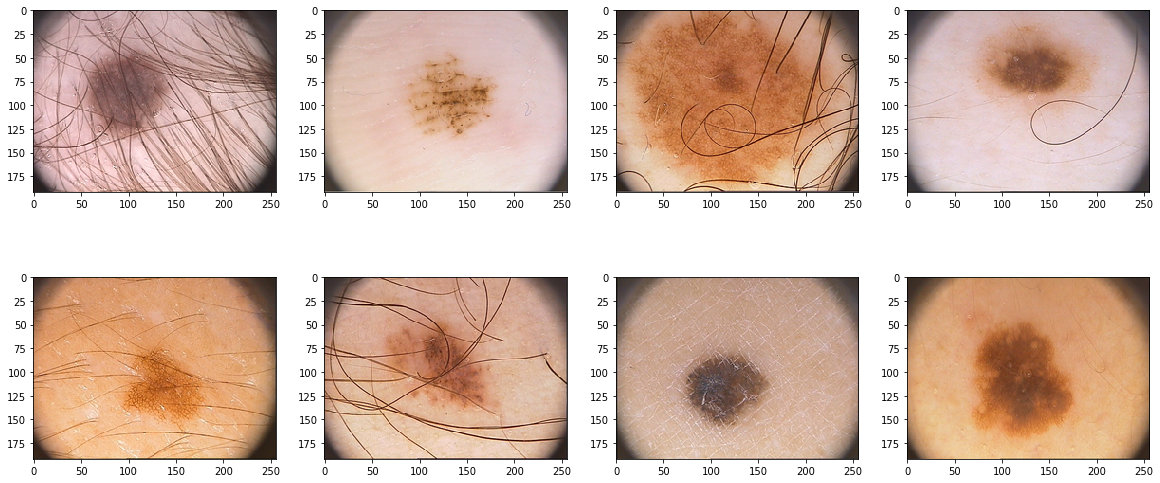

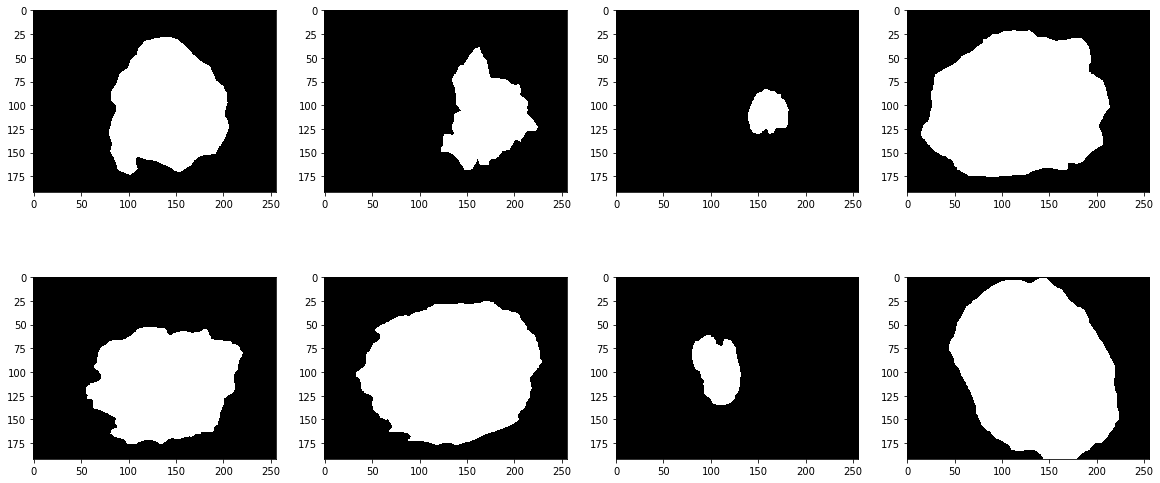

In [68]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(X_train_ph2[1])
plt.subplot(2,4,2)
plt.imshow(X_train_ph2[4])
plt.subplot(2,4,3)
plt.imshow(X_train_ph2[55])
plt.subplot(2,4,4)
plt.imshow(X_train_ph2[76])
plt.subplot(2,4,5)
plt.imshow(X_train_ph2[101])
plt.subplot(2,4,6)
plt.imshow(X_train_ph2[126])
plt.subplot(2,4,7)
plt.imshow(X_train_ph2[131])
plt.subplot(2,4,8)
plt.imshow(X_train_ph2[150])
plt.show()


plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(Y_train_ph2[0], cmap = plt.cm.binary_r)
plt.subplot(2,4,2)
plt.imshow(Y_train_ph2[3], cmap = plt.cm.binary_r)
plt.subplot(2,4,3)
plt.imshow(Y_train_ph2[54], cmap = plt.cm.binary_r)
plt.subplot(2,4,4)
plt.imshow(Y_train_ph2[77], cmap = plt.cm.binary_r)
plt.subplot(2,4,5)
plt.imshow(Y_train_ph2[100], cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(Y_train_ph2[125], cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(Y_train_ph2[130], cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(Y_train_ph2[149], cmap = plt.cm.binary_r)
plt.show()


In [69]:
def hair_remove(image):
 
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
 
    kernel = cv2.getStructuringElement(1,(17,17))
    

    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    

    _,threshold = cv2.threshold(blackhat,1,255,cv2.THRESH_BINARY)
    
   
    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)
    
    return final_image

Text(0.5, 1.0, 'Hair Removed')

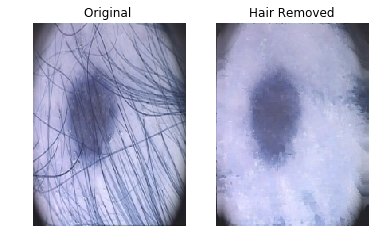

In [70]:
image_resize = cv2.resize(X_train_ph2[1],(192,256))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_resize, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original ')
    
final_image = hair_remove(image_resize)
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Hair Removed' )

In [71]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def precision(y_true, y_pred):
  
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
  
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def accuracy(y_true, y_pred):

    return K.mean(K.equal(y_true, K.round(y_pred)))

In [72]:
def rotation_aug(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_aug(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [73]:
def apply_data_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_nois = []
    for idx in range(len(x_train)):
        x,y = rotation_aug(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = horizontal_aug(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
        return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [74]:
x_rotated, y_rotated, x_flipped, y_flipped = apply_data_augmentation(x_train, y_train)
x_rotated_t, y_rotated_t, x_flipped_t, y_flipped_t = apply_data_augmentation(x_test, y_test)

In [75]:

x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

In [76]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)

In [77]:
print("Training Images  : {}".format(len(x_train)))
print("Testing Images       : {}".format(len(x_test)))
print("Validation Images : {}".format(len(x_val)))

Training Images  : 121
Testing Images       : 50
Validation Images : 31


In [78]:
INPUT_CHANNELS = 3
OUTPUT_MASK_CHANNELS = 1

def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
    if K.common.image_dim_ordering() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv


def UNET(epochs_num, savename):
    dropout_val=0.50
    if K.common.image_dim_ordering() == 'th':
        inputs = Input((INPUT_CHANNELS, 192, 256))
        axis = 1
    else:
        inputs = Input((192, 256, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)
    pred = Reshape((192, 256))(conv_final)
    model = Model(inputs, pred, name="UNET_224")
    model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coef, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 18, verbose=1)
    model.save(savename)
    return model, hist

In [79]:
def channel_attention(x, filter):

    dense_1 = tf.keras.layers.AveragePooling2D(pool_size=(1, 1))
    dense_2 = tf.keras.layers.Dense(filter/4, activation='relu') 
    dense_3 = tf.keras.layers.Dense(filter, activation='sigmoid') 

    x1 = dense_1(x)
    x1 = dense_2(x1)
    x1 = dense_3(x1)
    # x = x * x1
    x = tf.multiply(x, x1)
    return x

def spatial_attention(x):
    
    conv_1 = tf.keras.layers.Conv1D(filters=1, kernel_size=3, padding="same" ,activation='sigmoid') 
    
    x1 = conv_1(x)
    # x = x * x1
    x = tf.multiply(x, x1)
    return  x


def attention_module(x, filter, attention_type):

    if attention_type is 'channel':
        # Channel Attnetion only
        x = channel_attention(x,filter)
        output = x
        
    elif attention_type is 'spatial':
        # Spatial Attention only
        x = spatial_attention(x)
        output = x

    elif attention_type is 'parellel_add':
        x = channel_attention(x,filter) + spatial_attention(x)
        output = x

    elif attention_type is 'parellel_mul':
        # Parelle Attention (Mul)
        x = channel_attention(x,filter) * spatial_attention(x)
        output = x


    elif attention_type is 'serial_ca':
        # Serial Attention, CA first
        x = channel_attention(x,filter)
        x = spatial_attention(x)
        output = x

    elif attention_type is 'serial_sa':
        # Serial Attention, SA first
        x = spatial_attention(x)
        x = channel_attention(x,filter)
        output = x

    else:
        output  = x
    
    return output

In [80]:
model, hist = UNET(epochs_num= 100, savename= 'unet_100_epoch.h5')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 192, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 192, 256, 32) 896         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 192, 256, 32) 128         conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation_99 (Activation)      (None, 192, 256, 32) 0           batch_normalization_45[0][0]     
__________________________________________________________________________________________________
conv2d_48 

In [81]:
def proposed_img(img):
    sub1 = (model_unet.predict(img.reshape(1,192,256,3))).flatten()
    sub2 = (Proposed_Seg.predict(img.reshape(1,192,256,3))).flatten()
    sub = sub1[:]
    for i in range(len(sub)):
        sub[i] = (sub1[i] + sub2[i])/2
        
        if sub[i] > 0.7:
            sub[i] = 1
        else:
            sub[i] = 0

    return sub

In [82]:
def PS_Seg(epochs_num,savename):

    # Encoding layer
    img_input = Input(shape= (192, 256, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((192,256))(x)
    
    model = Model(inputs=img_input, outputs=pred)
    
    model.compile(optimizer= SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
                  , metrics=[iou, dice_coef, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 18, verbose=1)
    
    model.save(savename)
    return model,hist

In [83]:
model_2, hist_2 = PS_Seg(100, 'PS_100_epoch.h5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 192, 256, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 192, 256, 64)      1792      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 192, 256, 64)      256       
_________________________________________________________________
activation_122 (Activation)  (None, 192, 256, 64)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 192, 256, 64)      36928     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 192, 256, 64)      256       
_________________________________________________________________
activation_123 (Activation)  (None, 192, 256, 64)      0         
__________

Text(0.5, 1.0, 'Training Accuracy for Unet')

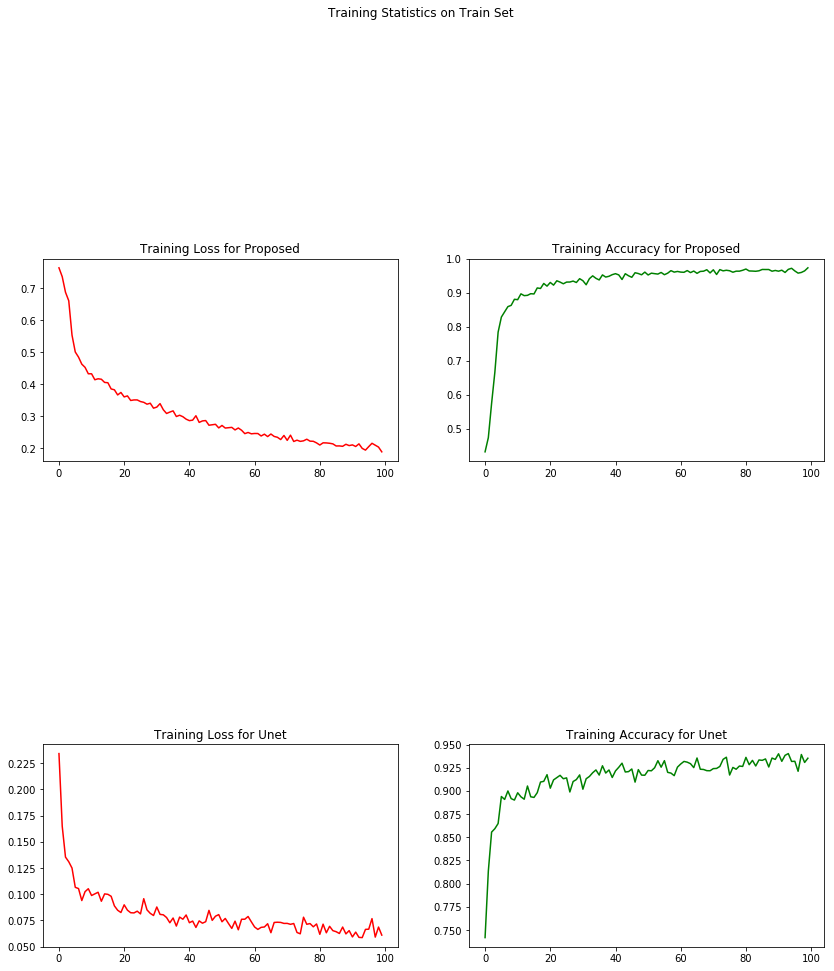

In [84]:
plt.figure(figsize=(14, 35))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(8,2,1)
plt.plot(hist_2.history['loss'], 'red')
plt.title('Training Loss for Proposed')
plt.subplot(8,2,2)
plt.plot(hist_2.history['accuracy'], 'green')
plt.title('Training Accuracy for Proposed')
plt.subplot(8,2,5)
plt.plot(hist.history['loss'], 'red')
plt.title('Training Loss for Unet')
plt.subplot(8,2,6)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Training Accuracy for Unet')



In [85]:
dropout_val=0.50
if K.common.image_dim_ordering() == 'th':
    inputs = Input((INPUT_CHANNELS, 192, 256))
    axis = 1
else:
    inputs = Input((192, 256, INPUT_CHANNELS))
    axis = 3
filters = 32

conv_224 = double_conv_layer(inputs, filters)
pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

conv_112 = double_conv_layer(pool_112, 2*filters)
pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

conv_56 = double_conv_layer(pool_56, 4*filters)
pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

conv_28 = double_conv_layer(pool_28, 8*filters)
pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

conv_14 = double_conv_layer(pool_14, 16*filters)
pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

conv_7 = double_conv_layer(pool_7, 32*filters)

up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
up_conv_14 = double_conv_layer(up_14, 16*filters)

up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
up_conv_28 = double_conv_layer(up_28, 8*filters)

up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
up_conv_56 = double_conv_layer(up_56, 4*filters)

up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
up_conv_112 = double_conv_layer(up_112, 2*filters)

up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
conv_final = Activation('sigmoid')(conv_final)
pred = Reshape((192, 256))(conv_final)

In [86]:
model_unet = Model(inputs, pred, name="UNET")
model_unet.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coef, precision, recall, accuracy])

In [87]:
model_unet.load_weights('unet_100_epoch.h5')


In [88]:
# Encoding layer
img_input = Input(shape= (192, 256, 3))
x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
x = BatchNormalization(name='bn1')(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
x = BatchNormalization(name='bn2')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
x = BatchNormalization(name='bn3')(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
x = BatchNormalization(name='bn4')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
x = BatchNormalization(name='bn5')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
x = BatchNormalization(name='bn6')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
x = BatchNormalization(name='bn7')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
x = BatchNormalization(name='bn8')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
x = BatchNormalization(name='bn9')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
x = BatchNormalization(name='bn10')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
x = BatchNormalization(name='bn11')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
x = BatchNormalization(name='bn12')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
x = BatchNormalization(name='bn13')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Dense(1024, activation = 'relu', name='fc1')(x)
x = Dense(1024, activation = 'relu', name='fc2')(x)
# Decoding Layer 
x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
x = BatchNormalization(name='bn14')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
x = BatchNormalization(name='bn15')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
x = BatchNormalization(name='bn16')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
x = BatchNormalization(name='bn17')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
x = BatchNormalization(name='bn18')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
x = BatchNormalization(name='bn19')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
x = BatchNormalization(name='bn20')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
x = BatchNormalization(name='bn21')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
x = BatchNormalization(name='bn22')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
x = BatchNormalization(name='bn23')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
x = BatchNormalization(name='bn24')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
x = BatchNormalization(name='bn25')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
x = BatchNormalization(name='bn26')(x)
x = Activation('sigmoid')(x)
pred = Reshape((192,256))(x)

In [89]:
Proposed_Seg = Model(inputs=img_input, outputs=pred)

Proposed_Seg.compile(optimizer= SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
              , metrics=[iou, dice_coef, precision, recall, accuracy])

In [90]:
Proposed_Seg.load_weights('PS_100_epoch.h5')



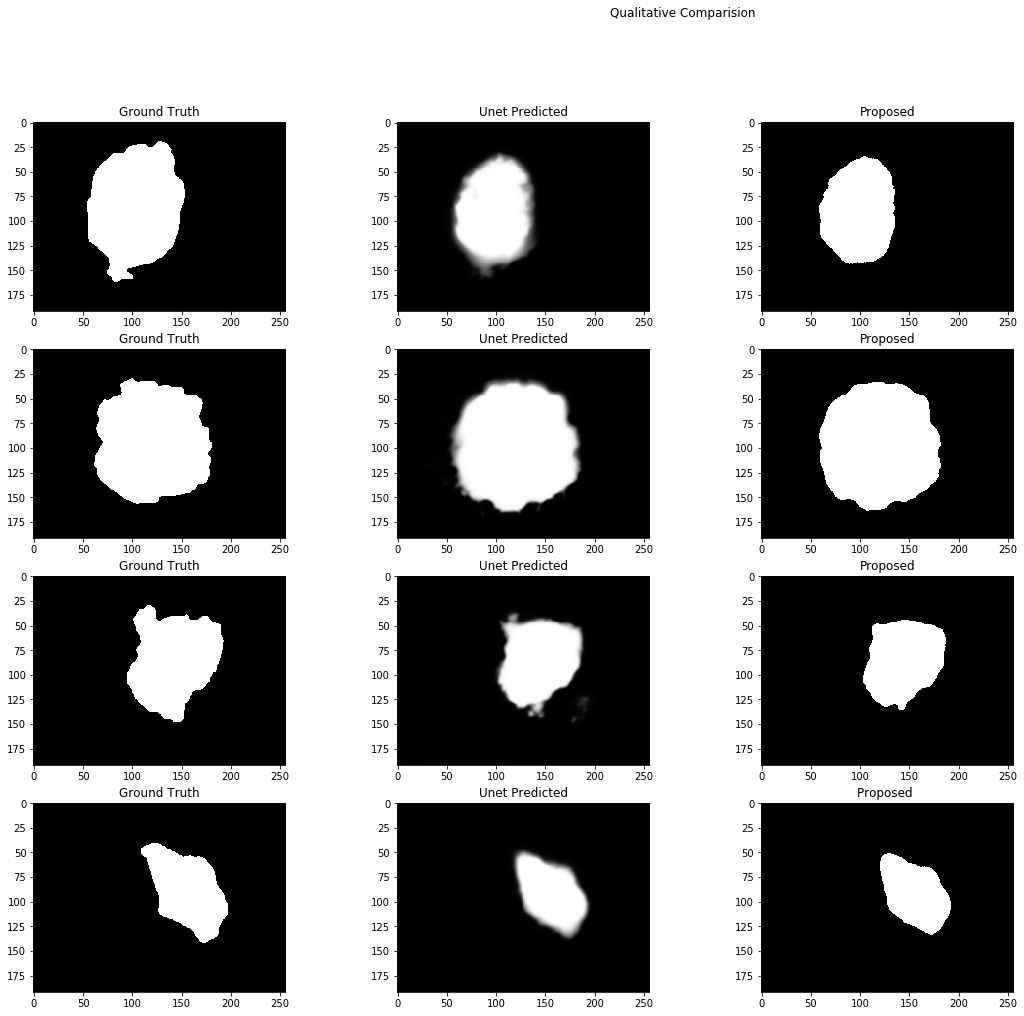

In [92]:
plt.figure(figsize=(25,16))
plt.suptitle('Qualitative Comparision')

img_num = 1
plt.subplot(4,4,1)
plt.imshow(y_test[img_num],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(4,4,2)

img_pred1 = model_unet.predict(x_test[img_num].reshape(1,192,256,3))


plt.imshow(img_pred1.reshape(192,256), plt.cm.binary_r)
plt.title('Unet Predicted')
plt.subplot(4,4,3)
plt.imshow(proposed_img(x_test[img_num]).reshape(192,256), plt.cm.binary_r)
plt.title('Proposed')


img_num = 2
plt.subplot(4,4,5)
plt.imshow(y_test[img_num],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(4,4,6)

img_pred1 = model_unet.predict(x_test[img_num].reshape(1,192,256,3))


plt.imshow(img_pred1.reshape(192,256), plt.cm.binary_r)
plt.title('Unet Predicted')
plt.subplot(4,4,7)
plt.imshow(proposed_img(x_test[img_num]).reshape(192,256), plt.cm.binary_r)
plt.title('Proposed')


img_num = 3
plt.subplot(4,4,9)
plt.imshow(y_test[img_num],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(4,4,10)

img_pred1 = model_unet.predict(x_test[img_num].reshape(1,192,256,3))


plt.imshow(img_pred1.reshape(192,256), plt.cm.binary_r)
plt.title('Unet Predicted')
plt.subplot(4,4,11)
plt.imshow(proposed_img(x_test[img_num]).reshape(192,256), plt.cm.binary_r)
plt.title('Proposed')


img_num = 4
plt.subplot(4,4,13)
plt.imshow(y_test[img_num],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(4,4,14)

img_pred1 = model_unet.predict(x_test[img_num].reshape(1,192,256,3))


plt.imshow(img_pred1.reshape(192,256), plt.cm.binary_r)
plt.title('Unet Predicted')
plt.subplot(4,4,15)
plt.imshow(proposed_img(x_test[img_num]).reshape(192,256), plt.cm.binary_r)
plt.title('Proposed ')

plt.show()